In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *

# Load the data

Data can be downloaded from [here](https://einstein.ai/research/the-wikitext-long-term-dependency-language-modeling-dataset). as suggested by smerity, we only add the eos flag at each end of sentence. 

In [3]:
EOS = '<eos>'
PATH=Path('../data/wikitext')

In [4]:
def read_file(filename):
    tokens = []
    with open(PATH/filename, encoding='utf8') as f:
        for line in f:
            tokens.append(line.split() + [EOS])
    return np.array(tokens)

In [5]:
trn_tok = read_file('wiki.train.tokens')
val_tok = read_file('wiki.valid.tokens')
tst_tok = read_file('wiki.test.tokens')

In [6]:
len(trn_tok), len(val_tok), len(tst_tok)

(36718, 3760, 4358)

Then we numericalize the tokens.

In [7]:
cnt = Counter(word for sent in trn_tok for word in sent)

In [8]:
cnt.most_common(10)

[('the', 113161),
 (',', 99913),
 ('.', 73388),
 ('of', 56889),
 ('<unk>', 54625),
 ('and', 50603),
 ('in', 39453),
 ('to', 39190),
 ('<eos>', 36718),
 ('a', 34237)]

In [9]:
itos = [o for o,c in cnt.most_common()]
itos.insert(0,'<pad>')

In [10]:
vocab_size = len(itos); vocab_size

33279

In [11]:
stoi = collections.defaultdict(lambda : 5, {w:i for i,w in enumerate(itos)})

In [12]:
trn_ids = np.array([([stoi[w] for w in s]) for s in trn_tok])
val_ids = np.array([([stoi[w] for w in s]) for s in val_tok])
tst_ids = np.array([([stoi[w] for w in s]) for s in tst_tok])

# Model

This is the usual AWD LSTM with three layers.

In [13]:
em_sz,nh,nl = 400,1150,3
bptt, bs = 70, 100

In [14]:
trn_dl = LanguageModelLoader(np.concatenate(trn_ids), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_ids), bs, bptt)
md = LanguageModelData(PATH, 0, vocab_size, trn_dl, val_dl, bs=bs, bptt=bptt)

In [15]:
drops_jh = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) #Jeremy's dropouts
drops_sm = np.array([0.5,0.4,0.5,0.1,0.3]) #Smerity's dropouts from the paper
drops = np.array([0.6,0.4,0.5,0.1,0.2]) #Smerity's dropouts from the github repo

Training schedule: 1cycle with either a third phase with cosine annealing or linear decay at one hundreth of the lowest lr. The second one seems to be slightly betters, but by a hair.

In [16]:
def one_cycle(steps,lr,div,max_mom,min_mom, wd):
    return [TrainingPhase(epochs=steps[0], opt_fn=optim.SGD, lr=(lr/div,lr), lr_decay=DecayType.LINEAR, 
                          momentum=(max_mom,min_mom), momentum_decay=DecayType.LINEAR, wds=wd),
           TrainingPhase(epochs=steps[1], opt_fn=optim.SGD, lr=(lr,lr/div), lr_decay=DecayType.LINEAR, 
                          momentum=(min_mom,max_mom), momentum_decay=DecayType.LINEAR, wds=wd),
           TrainingPhase(epochs=steps[2], opt_fn=optim.SGD, lr=lr/div, lr_decay=DecayType.COSINE, 
                          momentum=max_mom, wds=wd)]

In [17]:
def one_cycle_lin(steps,lr,div,max_mom,min_mom, wd):
    return [TrainingPhase(epochs=steps[0], opt_fn=optim.SGD, lr=(lr/div,lr), lr_decay=DecayType.LINEAR, 
                          momentum=(max_mom,min_mom), momentum_decay=DecayType.LINEAR, wds=wd),
           TrainingPhase(epochs=steps[1], opt_fn=optim.SGD, lr=(lr,lr/div), lr_decay=DecayType.LINEAR, 
                          momentum=(min_mom,max_mom), momentum_decay=DecayType.LINEAR, wds=wd),
           TrainingPhase(epochs=steps[2], opt_fn=optim.SGD, lr=(lr/div,lr/(div*100)), lr_decay=DecayType.LINEAR, 
                          momentum=max_mom, wds=wd)]

Helper functions for the evaluation of the model at the end. TextReader is rewritten from the LanguageModelLoader class to have a constant bptt and only one batch.

In [18]:
class TextReader():

    def __init__(self, nums, bptt, backwards=False):
        self.bptt,self.backwards = bptt,backwards
        self.data = self.batchify(nums)
        self.i,self.iter = 0,0
        self.n = len(self.data)

    def __iter__(self):
        self.i,self.iter = 0,0
        while self.i < self.n-1 and self.iter<len(self):
            res = self.get_batch(self.i, self.bptt)
            self.i += self.bptt
            self.iter += 1
            yield res

    def __len__(self): return self.n // self.bptt 

    def batchify(self, data):
        data = np.array(data)[:,None]
        if self.backwards: data=data[::-1]
        return T(data)

    def get_batch(self, i, seq_len):
        source = self.data
        seq_len = min(seq_len, len(source) - 1 - i)
        return source[i:i+seq_len], source[i+1:i+1+seq_len].view(-1)

Validation without reinitializing the hidden state.

In [19]:
def my_validate(model, source, bptt=2000):
    data_source = TextReader(source, bptt)
    model.eval()
    model.reset()
    total_loss = 0.
    targ_history = None
    hid_history = None
    for inputs, targets in tqdm(data_source):
        outputs, raws, outs = model(V(inputs))
        p_vocab = F.softmax(outputs,1)
        for i, pv in enumerate(p_vocab):
            targ_pred = pv[targets[i]]
            total_loss -= torch.log(targ_pred.detach())
    mean = total_loss / (bptt * len(data_source))
    return mean, np.exp(mean)

Cache pointer

In [20]:
def one_hot(vec, size=vocab_size):
    a = torch.zeros(len(vec), size)
    for i,v in enumerate(vec):
        a[i,v] = 1.
    return V(a)

def my_cache_pointer(model, source, theta = 0.662, lambd = 0.1279, window=200, bptt=2000):
    data_source = TextReader(source, bptt)
    model.eval()
    model.reset()
    total_loss = 0.
    targ_history = None
    hid_history = None
    for inputs, targets in tqdm(data_source):
        outputs, raws, outs = model(V(inputs))
        p_vocab = F.softmax(outputs,1)
        start = 0 if targ_history is None else targ_history.size(0)
        targ_history = one_hot(targets) if targ_history is None else torch.cat([targ_history, one_hot(targets)])
        hiddens = raws[-1].squeeze() #results of the last layer + remove the batch size.
        hid_history = hiddens if hid_history is None else torch.cat([hid_history, hiddens])
        for i, pv in enumerate(p_vocab):
            #Get the cached values
            p = pv
            if start + i > 0:
                targ_cache = targ_history[:start+i] if start + i <= window else targ_history[start+i-window:start+i]
                hid_cache = hid_history[:start+i] if start + i <= window else hid_history[start+i-window:start+i]
                all_dot_prods = torch.mv(theta * hid_cache, hiddens[i])
                exp_dot_prods = F.softmax(all_dot_prods).unsqueeze(1)
                p_cache = (exp_dot_prods.expand_as(targ_cache) * targ_cache).sum(0).squeeze()
                p = (1-lambd) * pv + lambd * p_cache
            targ_pred = p[targets[i]]
            total_loss -= torch.log(targ_pred.detach())
        targ_history = targ_history[-window:]
        hid_history = hid_history[-window:]
    mean = total_loss / (bptt * len(data_source))
    return mean, np.exp(mean)

Creation of the model with the best set of hyper-parameters I've found:
 - dropouts from the github repo
 - grad clipping at 0.25
 - AR and TAR loss with alpha=2 and beta=1
 - wd=1.2e-6 
Changing any one of those didn't yield better results.

In [27]:
opt_fn = partial(optim.SGD, momentum=0.95)
learner= md.get_model(opt_fn, em_sz, nh, nl,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1.2e-6

LR Finder

In [28]:
learner.lr_find(wds=wd, end_lr=1000)

 17%|█▋        | 51/297 [00:09<00:44,  5.55it/s, loss=10.4]
epoch      trn_loss   val_loss   accuracy                   
    0      28.393529  155.721588 0.053903  



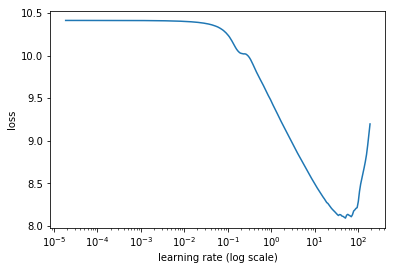

In [29]:
learner.sched.plot(10,25)

RNNs are very robust to large LRs and the gradient clipping will prevent divergence and explosion so we can take a LR near the minimum of the curve (30) (lesser values don't give as good a result). 

In [30]:
learner.fit_opt_sched(one_cycle_lin([30,30,30], 30, 10, 0.95, 0.85, wd))

epoch      trn_loss   val_loss   accuracy                   
    0      6.628112   6.184458   0.162373  
    1      6.153111   5.763566   0.19393                    
    2      5.871724   5.499626   0.218413                   
    3      5.671414   5.311994   0.226338                   
    4      5.514653   5.191954   0.2341                     
    5      5.382676   5.100694   0.237727                   
    6      5.28028    4.994971   0.245732                   
    7      5.197885   4.937758   0.248153                   
    8      5.129779   4.89894    0.24881                    
    9      5.086409   4.888917   0.246337                   
    10     5.022318   4.819836   0.254046                   
    11     4.961503   4.778642   0.257679                   
    12     4.943135   4.797901   0.251169                   
    13     4.893374   4.746737   0.257991                   
    14     4.858212   4.733589   0.257597                   
    15     4.853794   4.757826   0.256396

[4.300513040785696, 0.2911274534668408]

In [31]:
my_validate(learner.model, np.concatenate(val_ids))

100%|██████████| 108/108 [00:39<00:00,  2.75it/s]


(tensor(4.2898, device='cuda:0'), tensor(72.9502))

In [32]:
my_cache_pointer(learner.model, np.concatenate(val_ids), window=3785)

100%|██████████| 108/108 [07:50<00:00,  4.36s/it]


(tensor(4.0113, device='cuda:0'), tensor(55.2198))

Now if we go for a longer cycle...

In [33]:
opt_fn = partial(optim.SGD, momentum=0.95)
learner= md.get_model(opt_fn, em_sz, nh, nl,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1.2e-6

In [34]:
learner.fit_opt_sched(one_cycle_lin([50,50,50], 30, 10, 0.95, 0.85, wd))

epoch      trn_loss   val_loss   accuracy                   
    0      6.649408   6.197354   0.167872  
    1      6.195533   5.783183   0.200387                   
    2      5.918022   5.524694   0.215999                   
    3      5.690343   5.356249   0.22505                    
    4      5.537789   5.202367   0.233575                   
    5      5.414285   5.127078   0.235668                   
    6      5.307435   5.041664   0.23517                    
    7      5.212184   4.963502   0.246997                   
    8      5.149351   4.897415   0.248754                   
    9      5.090227   4.867299   0.251758                   
    10     5.010004   4.825522   0.254741                   
    11     4.962746   4.793763   0.256                      
    12     4.947663   4.79204    0.254782                   
    13     4.897349   4.757676   0.255848                   
    14     4.865117   4.72921    0.256547                   
    15     4.832319   4.713204   0.259961

[4.270147887631959, 0.2934068623857171]

In [35]:
my_validate(learner.model, np.concatenate(val_ids))

100%|██████████| 108/108 [00:39<00:00,  2.72it/s]


(tensor(4.2590, device='cuda:0'), tensor(70.7395))

(smerity is at 68 for the first trainign of a model)

In [36]:
my_cache_pointer(learner.model, np.concatenate(val_ids), window=3785)

100%|██████████| 108/108 [07:53<00:00,  4.39s/it]


(tensor(3.9722, device='cuda:0'), tensor(53.1025))

(smerity is at 52 for the model with cache pointer)